In [1]:
%matplotlib inline

from pathlib import Path

import math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools, stattools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots

In [9]:
# Load data and convert to time series
Amtrak_df = pd.read_csv('D:/Course/big data II/project/MA2.csv')
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Date, format='%Y/%m/%d')
ridership_ts = pd.Series(Amtrak_df.No.values, index=Amtrak_df.Date, name='Ridership')
ridership_ts.index = pd.DatetimeIndex(ridership_ts.index, freq=ridership_ts.index.inferred_freq)
Amtrak_df

Date       No
0  2020-03-24   1060.0
1  2020-03-25   1739.0
2  2020-03-26   2318.0
3  2020-03-27   3151.0
4  2020-03-28   4158.0
5  2020-03-29   4856.0
6  2020-03-30   5653.0
7  2020-03-31   6521.0
8  2020-04-01   7639.0
9  2020-04-02   8867.0
10 2020-04-03  10303.0
11 2020-04-04  11637.0
12 2020-04-05  12402.0
13 2020-04-06  13739.0
14 2020-04-07  15104.0
15 2020-04-08  16692.0
16 2020-04-09  18843.0
17 2020-04-10  20878.0
18 2020-04-11  22766.0
19 2020-04-12  25381.0
20 2020-04-13  26794.0
21 2020-04-14  28109.0
22 2020-04-15  29970.0
23 2020-04-16  32492.0
24 2020-04-17  35125.0
25 2020-04-18  37527.0
26 2020-04-19  39820.0
27 2020-04-20  41416.0
28 2020-04-21  43168.0
29 2020-04-22  44913.0
30 2020-04-23  47992.0
31 2020-04-24  50969.0
32 2020-04-25  53348.0
33 2020-04-26  54938.0
34 2020-04-27  56462.0
35 2020-04-28  58302.0
36 2020-04-29  60265.0
37 2020-04-30  62205.0
38 2020-05-01  64311.0
39 2020-05-02  66263.0
40 2020-05-03  68087.0
41 2020-05-04  69087.0

In [10]:
# fit a linear trend model to the time series 
ridership_df = tsatools.add_trend(ridership_ts, trend='ct')
ridership_lm = sm.ols(formula='Ridership ~ trend', data=ridership_df).fit()

In [12]:
# shorter and longer time series
ax = ridership_ts.plot()
ridership_lm.predict(ridership_df).plot(ax=ax)
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
ax.set_ylim(0, 100000)
plt.show()

In [13]:
# create short time series from 1997 to 1999 using a slice 
ridership_ts_3yrs = ridership_ts['1997':'1999']

In [14]:
# create a data frame with additional independent variables from time series
# the following command adds a constant term, a trend term and a quadratic trend term
ridership_df = tsatools.add_trend(ridership_ts, trend='ctt')
# fit a linear regression model to the time series
ridership_lm = sm.ols(formula='Ridership ~ trend + trend_squared', data=ridership_df).fit()

In [15]:
nValid = 3
nTrain = len(ridership_ts) - nValid

In [16]:
# partition the data
train_ts = ridership_ts[:nTrain]
valid_ts = ridership_ts[nTrain:]

In [17]:
# Generate the naive and seasonal naive forecast
naive_pred = pd.Series(train_ts[-1], index=valid_ts.index)
last_season = train_ts[-12:]
seasonal_pred = pd.Series(pd.concat([last_season]*5)[:len(valid_ts)].values, index=valid_ts.index)

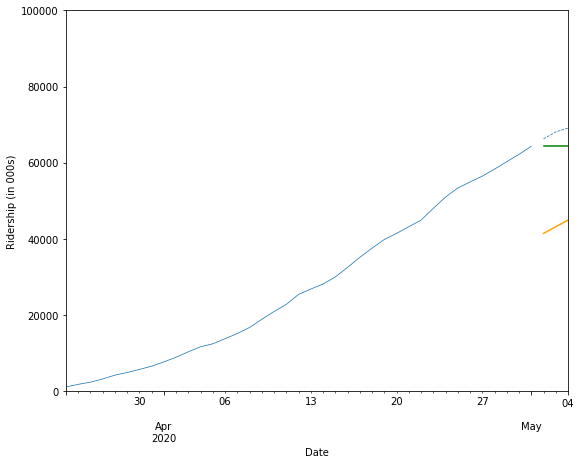

In [19]:
# plot forecasts and actual in the training and validation sets
ax = train_ts.plot(color='C0', linewidth=0.75, figsize=(9,7))
valid_ts.plot(ax=ax, color='C0', linestyle='dashed', linewidth=0.75)
ax.set_xlim('2020-3-17', '2020-5-04')
ax.set_ylim(0, 100000)
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')

naive_pred.plot(ax=ax, color='green')
seasonal_pred.plot(ax=ax, color='orange')

In [20]:
nValid = 3
nTrain = len(ridership_ts) - nValid

# partition the data
train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]

In [21]:
# Fit linear model using training set and predict on validation set
ridership_lm = sm.ols(formula='Ridership ~ trend', data=train_df).fit()
predict_df = ridership_lm.predict(valid_df)

In [27]:
# Create the graph
def singleGraphLayout(ax, ylim, train_df, valid_df):
    ax.set_xlim('2020-3-17', '2020-5-04')
    ax.set_ylim(0, 100000)
    ax.set_xlabel('Time')
    one_month = pd.Timedelta('1 days')
    xtrain = (min(train_df.index), max(train_df.index) - one_month)
    xvalid = (min(valid_df.index) + one_month, max(valid_df.index) - one_month)
    xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])

    ypos = 0.9 * ylim[1] + 0.1 * ylim[0]
    ax.add_line(plt.Line2D(xtrain, (ypos, ypos), color='black', linewidth=0.5))
    ax.add_line(plt.Line2D(xvalid, (ypos, ypos), color='black', linewidth=0.5))
    ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)

    ypos = 0.925 * ylim[1] + 0.075 * ylim[0]

In [28]:
def graphLayout(axes, train_df, valid_df):
    singleGraphLayout(axes[0], [1300, 2550], train_df, valid_df)
    singleGraphLayout(axes[1], [-550, 550], train_df, valid_df)
    train_df.plot(y='Ridership', ax=axes[0], color='C0', linewidth=0.75)
    valid_df.plot(y='Ridership', ax=axes[0], color='C0', linestyle='dashed', linewidth=0.75)
    axes[1].axhline(y=0, xmin=0, xmax=1, color='black', linewidth=0.5)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Confirmed')
    axes[1].set_ylabel('Forecast Errors')
    if axes[0].get_legend(): 
        axes[0].get_legend().remove()

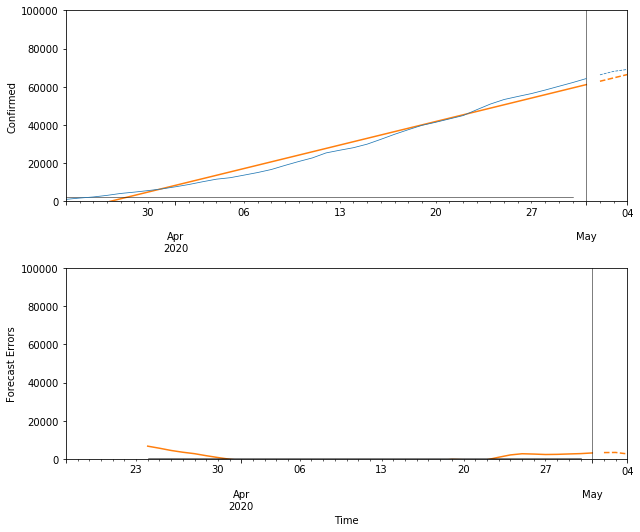

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))
ridership_lm.predict(train_df).plot(ax=axes[0], color='C1')
ridership_lm.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')

residual = train_df.Ridership - ridership_lm.predict(train_df)
residual.plot(ax=axes[1], color='C1')
residual = valid_df.Ridership - ridership_lm.predict(valid_df)
residual.plot(ax=axes[1], color='C1', linestyle='dashed')
graphLayout(axes, train_df, valid_df)

plt.tight_layout()
plt.show()

In [30]:
print(ridership_lm.summary())

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1805.
Date:                Tue, 05 May 2020   Prob (F-statistic):           5.27e-33
Time:                        21:56:09   Log-Likelihood:                -365.35
No. Observations:                  39   AIC:                             734.7
Df Residuals:                      37   BIC:                             738.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7422.5587    949.618     -7.816      0.0